<a href="https://colab.research.google.com/github/nikhilveldanda/INFO-5731/blob/main/Assignment4/INFO5731_Assignment_Four.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment Four**

In this assignment, you are required to conduct topic modeling, sentiment analysis based on **the dataset you created from assignment three**.

# **Question 1: Topic Modeling**

(30 points). This question is designed to help you develop a feel for the way topic modeling works, the connection to the human meanings of documents. Based on the dataset from assignment three, write a python program to **identify the top 10 topics in the dataset**. Before answering this question, please review the materials in lesson 8, especially the code for LDA and LSA. The following information should be reported:

(1) Features (top n-gram phrases) used for topic modeling.

(2) Top 10 clusters for topic modeling.

(3) Summarize and describe the topic for each cluster. 


In [43]:
!pip install selenium
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
chromium-chromedriver is already the newest version (95.0.4638.69-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
cp: '/usr/lib/chromium-browser/chromedriver' and '/usr/bin/chromedriver' are the same file


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: use options instead of chrome_options
  # This is added back by InteractiveShellApp.init_path()


In [44]:
import pandas as pd 
# Import Selenium and its sub libraries
import selenium 
from selenium import webdriver
# Import BS4
import requests
from bs4 import BeautifulSoup
from pandas.core.frame import DataFrame
import re

In [45]:
import nltk
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

In [95]:
def get_reviews(url) -> DataFrame:
  driver.get(url)
  driver.implicitly_wait(1) 
  # Set up action to click on 'load more' button
  page = 1
  while page<50:  
      try:
          load_more = driver.find_element_by_id('load-more-trigger')
          load_more.click()
          page+=1 
      except:
          break
  # After fully expand the page, we will grab data from whole website
  review = driver.find_elements_by_class_name('review-container')

  title = []
  content = []
  for n in range(len(review)):
      try:
          #Some reviewers only give review text or rating without the other, 
          #so we use try/except here to make sure each block of content must has all the element before append them to the list
          #Check if each review has all the elements
          ftitle = review[n].find_element_by_class_name('title').text
          fcontent = review[n].find_element_by_class_name('content').get_attribute("textContent").strip()

          #Then add them to the respective list
          title.append(ftitle)
          content.append(fcontent)
      except:
          continue
  #Build data dictionary for dataframe
  data = {
          'title': title,
          'text' : content
          
      }
  #Build dataframe for each movie to export
  review = pd.DataFrame(data = data)
  return review
data = get_reviews("https://www.imdb.com/title/tt6751668/reviews?ref_=tt_urv")
data.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  
/usr/local/lib/python3.7/dist-packages/selenium/webdriver/remote/webelement.py:446: UserWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  warnings.warn("find_element_by_* commands are deprecated. Please use find_element() instead")


,title,text
0,I loved the first 90%....but the last might be...,"I was able to see ""Parasite"" a few days ago at..."
1,Thoroughly entertaining,PARASITE is an excellent effort from Korean di...
2,class warfare,The Kim family leeches off others and lives in...
3,Totally Unique,Usually I don't read reviews before seeing a f...
4,"Fairly entertaining film, but one of 2019's be...","Okay, so these slightly over two hours are ""Pa..."


In [96]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
tokenizer = RegexpTokenizer(r'\w+')
p_stemmer = PorterStemmer()
from nltk.corpus import stopwords
en_stop = stopwords.words('english')

In [97]:
data['Lower Case'] = data['text'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
data['Tokenization'] = data['Lower Case'].apply(lambda x: tokenizer.tokenize(x))
data['Tokens'] = data['Tokenization'].apply(lambda x: [i for i in x if not i in en_stop])
data['Stemming'] = data['Tokens'].apply(lambda x: [p_stemmer.stem(i) for i in x])


In [50]:
texts = []
for line in data['Stemming']:
  texts.append(line)


In [51]:
# Bigrams and Trigrams
from gensim import corpora, models
bigram = models.Phrases(texts, min_count=5, threshold=100)
trigram = models.Phrases(bigram[texts], threshold=100)
bigram_mod = models.phrases.Phraser(bigram)
trigram_mod = models.phrases.Phraser(trigram)
print(trigram_mod[bigram_mod[texts[0]]])


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['abl', 'see', 'parasit', 'day', 'ago', 'philadelphia', 'film', 'festiv', 'mani', 'peopl', 'love', 'film', 'daughter', 'saw', 'think', 'product', 'valu', 'excel', 'end', 'chang', 'overal', 'feel', 'movi', 'untl', 'end', 'like', 'much', 'ultra', 'violent', 'climax', 'left', 'bit', 'cold', 'experi', 'film', 'realli', 'depend', 'whether', 'take', 'violenc', 'impact', 'instead', 'talk', 'plot', 'great', 'film', 'want', 'focu', 'violenc', 'daughter', 'felt', 'violenc', 'extrem', 'need', 'plot', 'see', 'knive', 'plung', 'peopl', 'close', 'rang', 'see', 'giant', 'rock', 'smash', 'ultra', 'realist', 'person', 'head', 'turn', 'stomach', 'could', 'violenc', 'without', 'extrem', 'person', 'close', 'overal', 'still', 'good', 'film', 'one', 'realli', 'wish', 'seen']


In [52]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [53]:
import spacy
data_words_bigrams = make_bigrams(texts)
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])


[['see', 'day', 'ago', 'film', 'daughter', 'see', 'think', 'product', 'overal', 'feel', 'movi', 'untl', 'end', 'much', 'ultra', 'violent', 'climax', 'leave', 'bit', 'cold', 'film', 'realli', 'depend', 'take', 'violenc', 'impact', 'instead', 'talk', 'plot', 'film', 'want', 'daughter', 'feel', 'extrem', 'need', 'plot', 'see', 'see', 'giant', 'rock', 'person', 'head', 'turn', 'stomach', 'could', 'violenc', 'extrem', 'person', 'close', 'overal', 'still', 'good', 'film', 'realli', 'wish', 'see']]


In [54]:
# Preparing Corpus and Dictionary
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 2), (11, 2), (12, 4), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 2), (24, 2), (25, 1), (26, 2), (27, 1), (28, 5), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 1)]]


[[('ago', 1),
  ('bit', 1),
  ('climax', 1),
  ('close', 1),
  ('cold', 1),
  ('could', 1),
  ('daughter', 2),
  ('day', 1),
  ('depend', 1),
  ('end', 1),
  ('extrem', 2),
  ('feel', 2),
  ('film', 4),
  ('giant', 1),
  ('good', 1),
  ('head', 1),
  ('impact', 1),
  ('instead', 1),
  ('leave', 1),
  ('movi', 1),
  ('much', 1),
  ('need', 1),
  ('overal', 2),
  ('person', 2),
  ('plot', 2),
  ('product', 1),
  ('realli', 2),
  ('rock', 1),
  ('see', 5),
  ('still', 1),
  ('stomach', 1),
  ('take', 1),
  ('talk', 1),
  ('think', 1),
  ('turn', 1),
  ('ultra', 1),
  ('untl', 1),
  ('violenc', 2),
  ('violent', 1),
  ('want', 1),
  ('wish', 1)]]

In [55]:
# LDA
lda_model = models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics = 20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)



In [56]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0, '0.089*"plan" + 0.041*"class" + 0.025*"social" + 0.023*"relationship" + 0.020*"remain" + 0.018*"form" + 0.017*"mark" + 0.016*"conflict" + 0.016*"core" + 0.015*"director"'), (1, '0.246*"help" + 0.138*"find" + 0.136*"review" + 0.119*"sign_vote" + 0.119*"permalink" + 0.033*"watch" + 0.021*"good" + 0.018*"movi" + 0.010*"hype" + 0.009*"great"'), (2, '0.107*"poor" + 0.091*"rich" + 0.047*"famili" + 0.044*"live" + 0.035*"job" + 0.030*"hous" + 0.026*"son" + 0.025*"man" + 0.022*"basement" + 0.020*"peopl"'), (3, '0.037*"ahead" + 0.034*"nonsen" + 0.027*"hob" + 0.021*"damn" + 0.019*"phenoman" + 0.017*"accid" + 0.017*"honesti" + 0.016*"current" + 0.015*"quot" + 0.015*"pattern"'), (4, '0.036*"gap" + 0.035*"visit" + 0.025*"grotesqu" + 0.025*"small" + 0.023*"keeper" + 0.021*"everyday" + 0.020*"locat" + 0.015*"match" + 0.014*"suck" + 0.013*"ugli"'), (5, '0.049*"film" + 0.020*"good" + 0.019*"parasit" + 0.014*"see" + 0.014*"end" + 0.013*"make" + 0.013*"get" + 0.012*"even" + 0.011*"go" + 0.011*"think"

In [57]:
from gensim.models import CoherenceModel
print('\nPerplexity: ', lda_model.log_perplexity(corpus))
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -6.981664524045597

Coherence Score:  0.48290773705040985


In [58]:
# LSA 
lsamodel = models.LsiModel(corpus, num_topics = 20, id2word = id2word)
print(lsamodel.print_topics(num_topics = 20))

[(0, '0.507*"film" + 0.235*"good" + 0.231*"movi" + 0.193*"parasit" + 0.191*"make" + 0.170*"see" + 0.144*"get" + 0.144*"help" + 0.134*"poor" + 0.134*"rich"'), (1, '-0.634*"help" + -0.327*"review" + -0.318*"sign_vote" + -0.318*"permalink" + -0.306*"find" + 0.287*"film" + -0.214*"movi" + -0.076*"watch" + 0.070*"parasit" + 0.055*"live"'), (2, '0.684*"film" + -0.441*"movi" + -0.216*"rich" + 0.173*"help" + -0.171*"make" + -0.161*"peopl" + -0.160*"poor" + -0.111*"get" + -0.109*"would" + -0.099*"even"'), (3, '0.462*"movi" + -0.419*"rich" + -0.367*"poor" + 0.212*"good" + -0.192*"famili" + -0.171*"live" + -0.168*"help" + 0.131*"feel" + -0.124*"hous" + -0.119*"son"'), (4, '-0.455*"good" + -0.333*"poor" + -0.288*"rich" + -0.284*"movi" + 0.200*"go" + 0.178*"feel" + -0.172*"film" + 0.146*"get" + 0.143*"would" + 0.131*"parasit"'), (5, '-0.656*"good" + 0.286*"movi" + 0.261*"film" + -0.243*"parasit" + 0.180*"poor" + 0.169*"rich" + 0.169*"feel" + -0.115*"get" + 0.113*"make" + -0.107*"pictur"'), (6, '-0.

# LDA
one film family ki really two bong kim movie great 
 
helpful home original movie son surprises vote even 16 far 
 
people well movie helpful rich big watch rock story wants 
 
family helpful parasite watch film movie ho bong way wealthy 

helpful film sign vote found review permalink 10 movie first 

smell 17 also helpful story get family rich well kim 

film social new like movie helpful things one glad time 

ki park family woo kim film taek ho jung parasite 

helpful 10 movie film vote sign permalink review found excellent 

helpful movie film review sign vote permalink found one family 

# LSA
film family poor ki parks kims class even park kim strong woo bong movie parasite people one parasites rich house 

helpful movie film review sign permalink vote found one family good parasite best like story movies watch really great people 

family helpful great well wealthy cast movie fine interest 10 good need around film intense simple social permalink development vote 

family parasite film bong helpful movie ho entertaining well class one like joon another despite best way suspense films poor 

film family tragedy deserved person south recommended totally quite want personal finds see exciting pure ok course films jobs something 

superb written theme family get mix social serious done commentary geun film poor well hate message comedy become drama great 

helpful movie 10 film vote many films sign review found permalink best surprises good make drama things one really parasite 

surprises trying bit well kims housekeeper guess kim admit movie job enjoyed written issue little end really helpful son going 

family kim ki rich buy father woo mother son better basement girl gets parasite south sister mom would dad member 

people family garden film far previous apartment window underground nice long also twist horrible con really rock kevin written twists

In [106]:
l1 = [(0, '0.507*"film" + 0.235*"good" + 0.231*"movi" + 0.193*"parasit" + 0.191*"make" + 0.170*"see" + 0.144*"get" + 0.144*"help" + 0.134*"poor" + 0.134*"rich"'), (1, '-0.634*"help" + -0.327*"review" + -0.318*"sign_vote" + -0.318*"permalink" + -0.306*"find" + 0.287*"film" + -0.214*"movi" + -0.076*"watch" + 0.070*"parasit" + 0.055*"live"'), (2, '0.684*"film" + -0.441*"movi" + -0.216*"rich" + 0.173*"help" + -0.171*"make" + -0.161*"peopl" + -0.160*"poor" + -0.111*"get" + -0.109*"would" + -0.099*"even"'), (3, '0.462*"movi" + -0.419*"rich" + -0.367*"poor" + 0.212*"good" + -0.192*"famili" + -0.171*"live" + -0.168*"help" + 0.131*"feel" + -0.124*"hous" + -0.119*"son"'), (4, '-0.455*"good" + -0.333*"poor" + -0.288*"rich" + -0.284*"movi" + 0.200*"go" + 0.178*"feel" + -0.172*"film" + 0.146*"get" + 0.143*"would" + 0.131*"parasit"'), (5, '-0.656*"good" + 0.286*"movi" + 0.261*"film" + -0.243*"parasit" + 0.180*"poor" + 0.169*"rich" + 0.169*"feel" + -0.115*"get" + 0.113*"make" + -0.107*"pictur"'), (6, '-0.602*"parasit" + 0.260*"get" + 0.220*"movi" + -0.184*"also" + -0.167*"feel" + 0.159*"see" + -0.157*"poor" + 0.129*"son" + -0.119*"think" + 0.118*"go"'), (7, '-0.343*"parasit" + -0.342*"movi" + 0.279*"would" + -0.204*"live" + 0.192*"good" + -0.183*"famili" + 0.179*"feel" + -0.176*"park" + 0.163*"rich" + -0.159*"hous"'), (8, '-0.496*"see" + 0.399*"make" + -0.247*"parasit" + -0.197*"watch" + -0.193*"famili" + -0.162*"say" + -0.151*"rich" + 0.144*"class" + 0.142*"work" + 0.123*"good"'), (9, '-0.378*"also" + 0.285*"parasit" + -0.252*"see" + 0.225*"get" + 0.224*"famili" + 0.220*"end" + 0.212*"make" + -0.193*"live" + -0.143*"hous" + -0.134*"feel"'), (10, '0.304*"feel" + 0.303*"end" + -0.266*"make" + -0.209*"time" + -0.205*"watch" + -0.191*"rich" + 0.188*"famili" + 0.188*"also" + 0.154*"get" + 0.136*"bad"'), (11, '0.343*"see" + -0.320*"think" + -0.259*"go" + 0.234*"end" + 0.201*"watch" + -0.200*"get" + -0.187*"say" + 0.178*"class" + -0.143*"way" + 0.128*"well"'), (12, '-0.437*"see" + 0.364*"watch" + -0.352*"make" + 0.212*"would" + -0.161*"also" + 0.140*"hous" + -0.137*"work" + 0.134*"first" + 0.129*"movi" + 0.125*"never"'), (13, '-0.413*"would" + 0.354*"watch" + 0.227*"make" + 0.204*"feel" + 0.199*"go" + -0.161*"well" + -0.155*"end" + -0.154*"movi" + 0.150*"good" + -0.148*"work"'), (14, '-0.391*"time" + -0.326*"go" + 0.319*"think" + 0.256*"get" + 0.207*"make" + -0.191*"class" + -0.142*"come" + 0.130*"also" + 0.128*"live" + 0.124*"peopl"'), (15, '0.285*"go" + 0.204*"class" + -0.195*"first" + 0.192*"hous" + -0.183*"time" + 0.181*"much" + 0.161*"get" + 0.148*"would" + 0.144*"plan" + 0.144*"peopl"'), (16, '-0.332*"watch" + -0.288*"great" + 0.266*"even" + -0.265*"think" + 0.219*"peopl" + 0.202*"say" + -0.186*"go" + -0.167*"end" + -0.161*"way" + 0.161*"come"'), (17, '0.346*"would" + 0.305*"famili" + -0.261*"end" + -0.239*"get" + -0.230*"class" + 0.195*"hous" + 0.149*"go" + -0.146*"even" + 0.143*"make" + 0.140*"well"'), (18, '-0.240*"get" + -0.211*"poor" + 0.210*"say" + 0.206*"scene" + 0.182*"famili" + 0.174*"end" + -0.171*"well" + -0.165*"work" + -0.165*"see" + -0.154*"time"'), (19, '0.367*"take" + -0.238*"first" + 0.229*"feel" + -0.215*"even" + -0.213*"also" + 0.189*"end" + -0.187*"go" + 0.175*"would" + -0.165*"great" + -0.145*"get"')]


# **Question 2: Sentiment Analysis**

(30 points). Sentiment analysis also known as opinion mining is a sub field within Natural Language Processing (NLP) that builds machine learning algorithms to classify a text according to the sentimental polarities of opinions it contains, e.g., positive, negative, neutral. The purpose of this question is to develop a machine learning classifier for sentiment analysis. Based on the dataset from assignment three, write a python program to implement a sentiment classifier and evaluate its performance. Notice: **80% data for training and 20% data for testing**.  

(1) Features used for sentiment classification and explain why you select these features.

(2) Select two of the supervised learning algorithm from scikit-learn library: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning, to build a sentiment classifier respectively. 

(3) Compare the performance over accuracy, precision, recall, and F1 score for the two algorithms you selected. Here is the reference of how to calculate these metrics: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9. 

In [61]:
data = pd.read_csv("/content/Reviews_analysis.csv")
data.head()

,document_id,clean_text,sentiment
0,1,"If you make a plan, life never works out that ...",Positive
1,2,"With no plan, nothing can go wrong",Negative
2,3,You can't go wrong with no plans,Negative
3,4,10,Positive
4,5,A Solid Metaphor Film,Neutral


Neutral     42
Positive    41
Negative    17
Name: sentiment, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


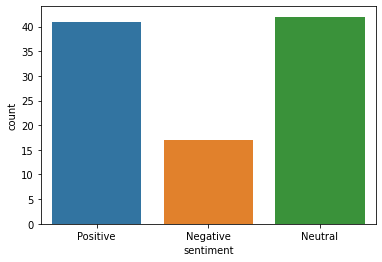

In [62]:
import seaborn as sns
print(data['sentiment'].value_counts())
sns.countplot(data.sentiment)

In [63]:
# Feature selection
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidfvector = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
Tfidfvector.fit(data['clean_text'])
x_values = Tfidfvector.transform(data['clean_text'])
encoder = LabelEncoder()
y_values = encoder.fit_transform(data['sentiment'])


In [64]:
from sklearn import model_selection
X_train, x_test, y_train, y_test = model_selection.train_test_split(x_values, y_values, test_size=0.2)


In [65]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import svm
svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, y_train)
predicted = svm_model.predict(x_test)
print("Accuracy score is {0}".format(accuracy_score(y_test, predicted)))
report = classification_report(y_test, predicted, output_dict=True)
report


Accuracy score is 0.65


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'0': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 4},
 '1': {'f1-score': 0.7058823529411765,
  'precision': 0.6666666666666666,
  'recall': 0.75,
  'support': 8},
 '2': {'f1-score': 0.7368421052631579,
  'precision': 0.6363636363636364,
  'recall': 0.875,
  'support': 8},
 'accuracy': 0.65,
 'macro avg': {'f1-score': 0.4809081527347781,
  'precision': 0.4343434343434343,
  'recall': 0.5416666666666666,
  'support': 20},
 'weighted avg': {'f1-score': 0.5770897832817338,
  'precision': 0.5212121212121212,
  'recall': 0.65,
  'support': 20}}

In [66]:
from sklearn import naive_bayes
nb = naive_bayes.MultinomialNB()
nb.fit(X_train, y_train)
predicted_nb = nb.predict(x_test)
print("Accuracy score is {0}".format(accuracy_score(y_test, predicted_nb)))
report_nb = classification_report(y_test, predicted_nb, output_dict=True)
report_nb


Accuracy score is 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'0': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 4},
 '1': {'f1-score': 0.608695652173913,
  'precision': 0.4666666666666667,
  'recall': 0.875,
  'support': 8},
 '2': {'f1-score': 0.4615384615384615,
  'precision': 0.6,
  'recall': 0.375,
  'support': 8},
 'accuracy': 0.5,
 'macro avg': {'f1-score': 0.3567447045707915,
  'precision': 0.35555555555555557,
  'recall': 0.4166666666666667,
  'support': 20},
 'weighted avg': {'f1-score': 0.4280936454849498,
  'precision': 0.42666666666666664,
  'recall': 0.5,
  'support': 20}}

I have selected the Naive Bayes and SVM. Below are metrics of the two models

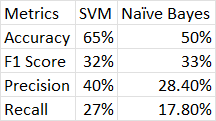

# **Question 3: House price prediction**

(40 points). You are required to build a **regression** model to predict the house price with 79 explanatory variables describing (almost) every aspect of residential homes. The purpose of this question is to practice regression analysis, an supervised learning model. The training data, testing data, and data description files can be download here: https://github.com/unt-iialab/info5731_spring2021/blob/main/assignment/assignment4-question3-data.zip. Here is an axample for implementation: https://towardsdatascience.com/linear-regression-in-python-predict-the-bay-areas-home-price-5c91c8378878. 


In [67]:
# Write your code here
train_dataset = pd.read_csv("/content/train.csv")
test_dataset = pd.read_csv("/content/test.csv")

In [68]:
train_dataset.describe()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [69]:
print(train_dataset.isnull().sum())


Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64


In [70]:
print(test_dataset.isnull().sum())


Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64


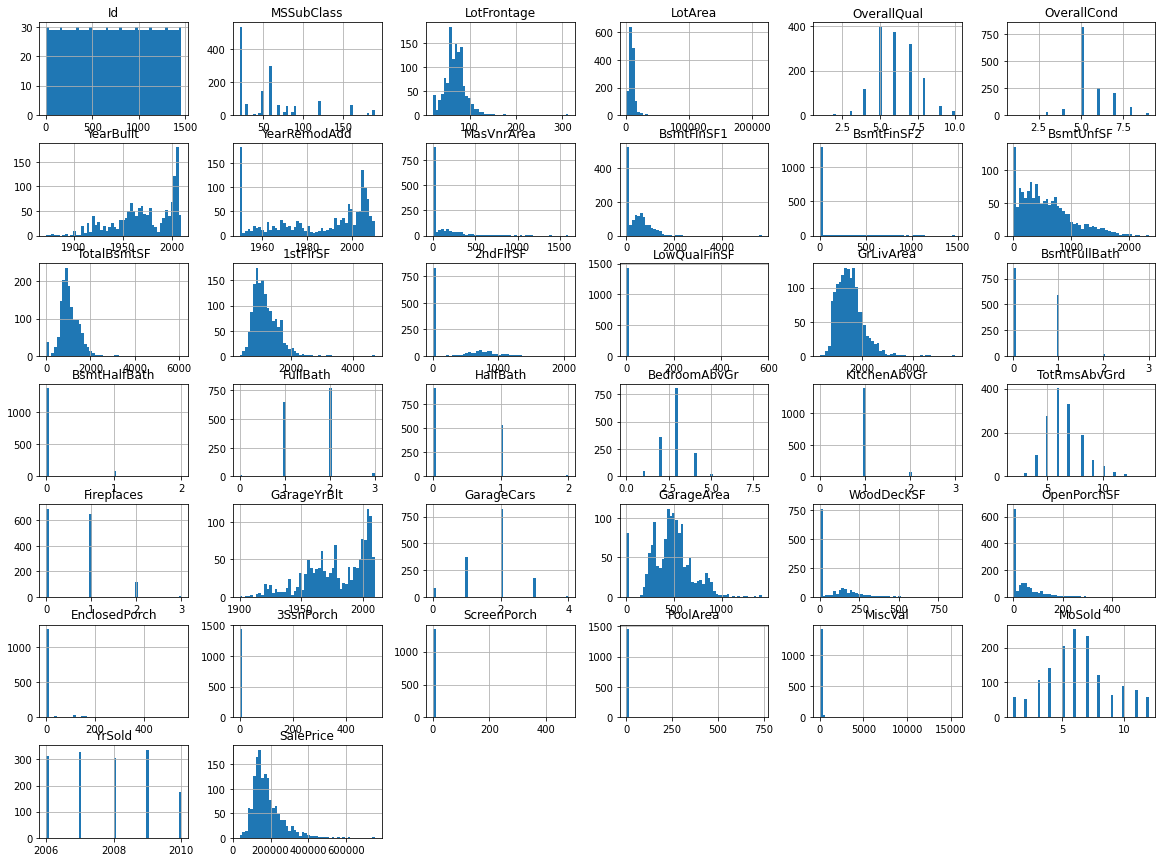

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
train_dataset.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()


In [72]:
corr_matrix = train_dataset.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

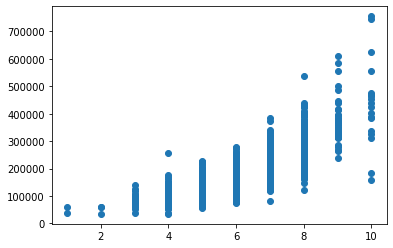

In [73]:
plt.scatter(train_dataset['OverallQual'],train_dataset['SalePrice'])

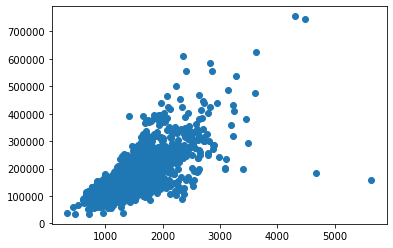

In [74]:
plt.scatter(train_dataset['GrLivArea'],train_dataset['SalePrice'])

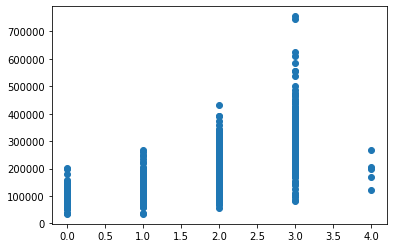

In [75]:
plt.scatter(train_dataset['GarageCars'],train_dataset['SalePrice'])

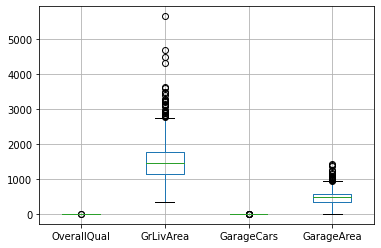

In [76]:
train_dataset.boxplot(column=['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea'])


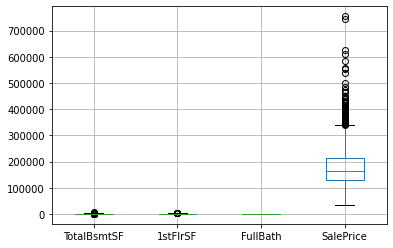

In [77]:
train_dataset.boxplot(column=['TotalBsmtSF', '1stFlrSF', 'FullBath', 'SalePrice'])


In [78]:
train_dataset.fillna(0, inplace = True)
test_dataset.fillna(0, inplace = True)


In [79]:
from sklearn.preprocessing import LabelEncoder
columns = ('GarageCond', 'LandContour', 'RoofStyle', 'RoofMatl', 'Heating', 'MiscFeature', 'SaleType', 'GarageType', 'Electrical', 'SaleCondition', 'Foundation', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'FireplaceQu', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'Utilities', 'BldgType', 'HouseStyle','PoolQC', 'BsmtQual', 'BsmtCond', 'GarageQual','BsmtExposure', 'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1','BsmtFinType2', 'Functional', 'Fence', 'GarageFinish', 'LandSlope','LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 'YrSold', 'MoSold', 'MSZoning')
for column in columns:
    encoder = LabelEncoder()
    encoder.fit(list(train_dataset[column].values))
    train_dataset[column] = encoder.transform(list(train_dataset[column].values))

In [80]:
for column in columns:
    encoder_test = LabelEncoder()
    encoder_test.fit(list(test_dataset[column].values))
    test_dataset[column] = encoder_test.transform(list(test_dataset[column].values))


In [81]:
x_values = train_dataset[train_dataset.columns[:80]] 
x_test_values = test_dataset[test_dataset.columns[:80]]
y_values = train_dataset['SalePrice']


In [82]:
from sklearn.linear_model import LinearRegression
reg_model = LinearRegression()
reg_model.fit(x_values, y_values)
reg_model.score(x_values, y_values)


0.8679043761275973

In [83]:
# Predicting the House Sale Price
predicted = reg_model.predict(x_test_values)
pd.DataFrame({'Predicted House Price Values': predicted})


,Predicted House Price Values
0,61193.197323
1,111326.720904
2,116488.715460
3,136402.379346
4,135085.606164
...,...
1454,29583.161170
1455,4756.354147
1456,105989.553797
1457,71921.408420
